# heart-attack-analysis: PCA + Clustering

## 1. Intro

I found this dataset on Kaggle (https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset).

This dataset contains information about people and there chances of having a heart stroke. The main purpose of it is classification,
but I want to use it for clustering.

### 1.1. Main Goal

The main goals are:
* perform dimensionality reduction;
* To classify/cluster patients in the dataset based on numerical and categorical features.

### 1.2. Benefits

The benefits of this analysis are:
* We may find some hidden dependency between features
* We will try to get a 2 clusters that represent patients with heart attack and without

### 1.3. Dataset description

This dataset contains information about people and there chances of having a heart attack.


`age` - Age of the patient: binary

`sex` - Sex of the patient: int

`cp` - Chest pain type: int

* 0 = Typical Angina,
* 1 = Atypical Angina,
* 2 = Non-anginal Pain,
* 3 = Asymptomatic

`trtbps` - Resting blood pressure (in mm Hg): int

`chol` - Cholestoral in mg/dl fetched via BMI sensor: int

`fbs` - (fasting blood sugar > 120 mg/dl): binary
* 1 = True,
* 0 = False

`restecg` - Resting electrocardiographic results: int
* 0 = Normal,
* 1 = ST-T wave normality,
* 2 = Left ventricular hypertrophy

`thalachh`  - Maximum heart rate achieved : int

`oldpeak` - Previous peak: float

`slp` - Slope: inint in [0,1,2]

`caa` - Number of major vessels: int in [0,1,2]

`thall` - Thalium Stress Test result: int in [0,1,2,3]

`exng` - Exercise induced angina: binary
* 1 = Yes,
* 0 = No

`output` - Target variable: int
* 1 = Yes
* 0 = No

####

### 1.4. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## 2. Data description and data cleaning


### Load the dataset:

In [2]:
df = pd.read_csv("data/heart.csv")
df = df.drop(['output'],axis=1)

### 2.1. Data description

Here we get some basic information about data, data types and values

#### First 5 rows of the data:

In [3]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


#### Shape of the dataset

In [4]:
print("The shape of the dataset is : ", df.shape)

The shape of the dataset is :  (303, 13)


#### Types of data

In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
dtype: object

All datatypes are numeric, but soome of them also categorical.

#### Unique values

In [6]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"])

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
unique count,41,2,4,49,152,2,3,91,2,40,3,5,4


#### Separating columns:


Dataset has several features that are categorical but encoded using int values

In [7]:
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", con_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
The continuous cols are :  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
The target variable is :   ['output']


#### Summary statistics

In [8]:
df[con_cols].describe()

,age,trtbps,chol,thalachh,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


### 2.2 Data cleaning
Here we will check the data for missing values and duplicated rows.
And then remove all occurrences to get clean data.

#### Check for missing values:

In [9]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
dtype: int64

There is no missing values.

#### Check for duplicated rows

In [10]:
df[df.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2


There is 1 duplication

#### Remove duplication

In [11]:
df.drop_duplicates(keep='first',inplace=True)

#### Now data is clean and ready for analysis

## 3. EDA

###  3.1. Analysis of 1 feature

#### 3.1.1 Categorical features

In [12]:
def categorical_plot(df, feature_name):
    fig = plt.figure(figsize=(12,6))
    gs = fig.add_gridspec(3,3)
    gs.update(wspace=0.5, hspace=0.25)
    ax=plt.axes()
    ax.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    return sns.countplot(data=df, x=feature_name)

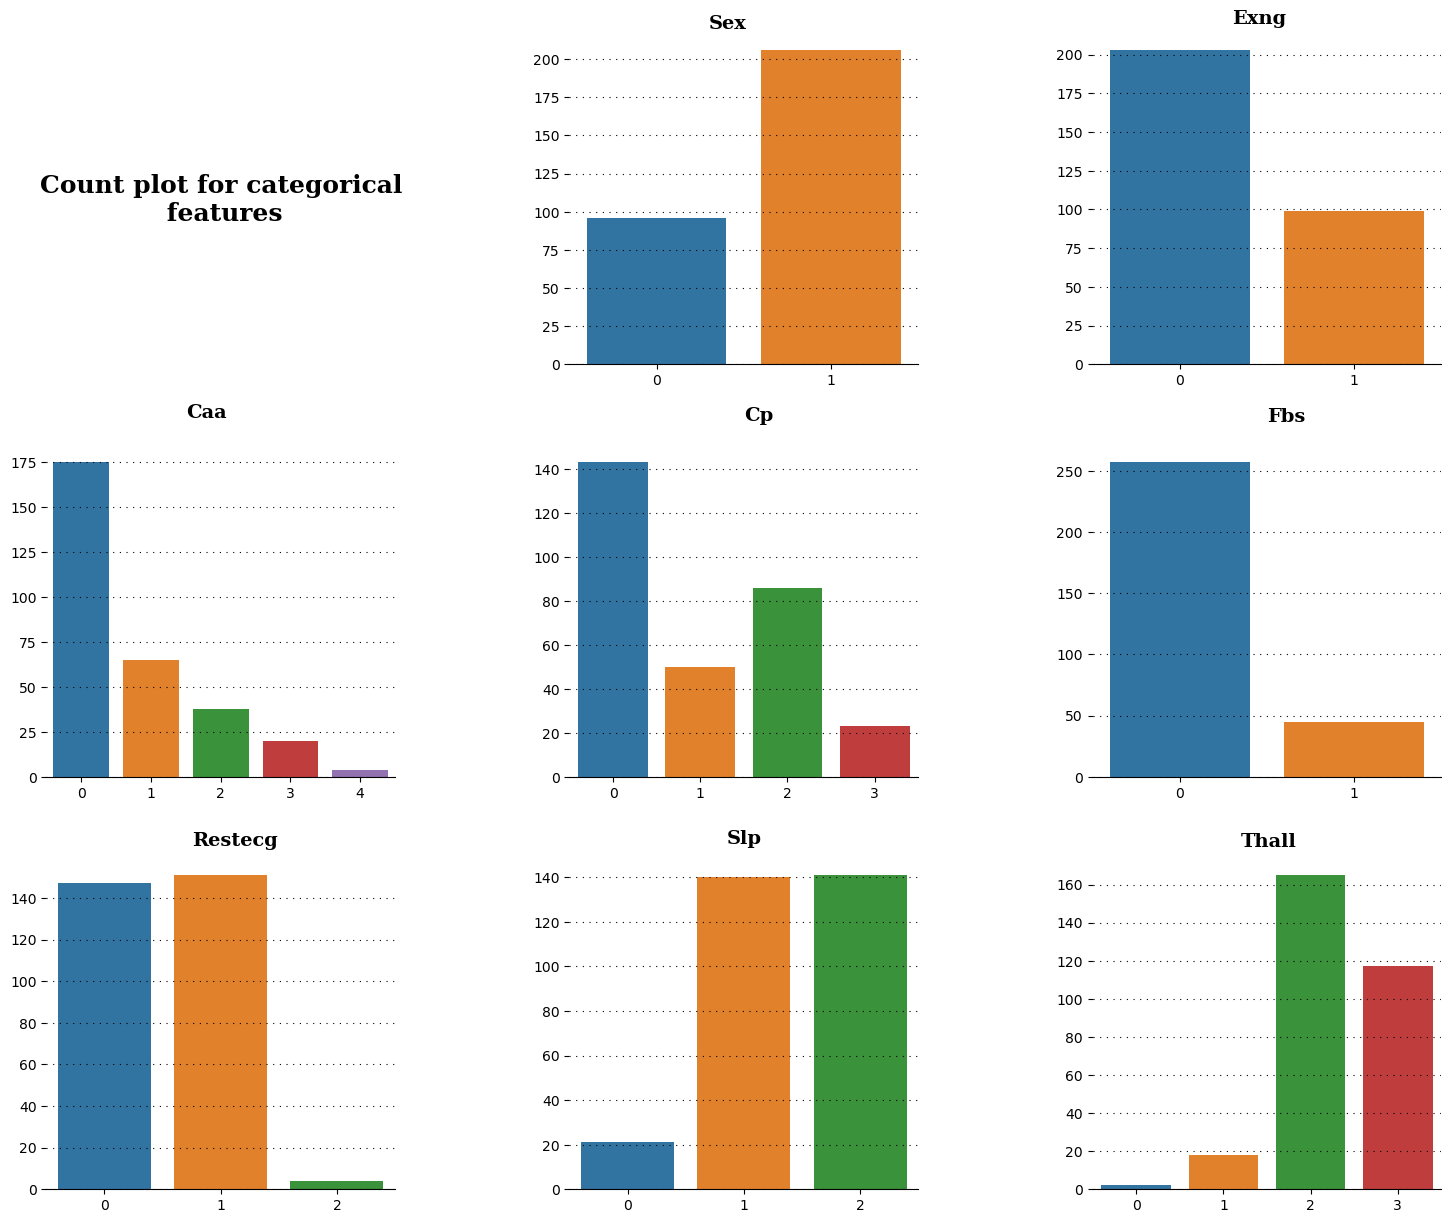

In [13]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for categorical\n features',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Sex count
ax1.text(0.3, 220, 'Sex', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1,data=df,x='sex')
ax1.set_xlabel("")
ax1.set_ylabel("")

# Exng count
ax2.text(0.3, 220, 'Exng', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2,data=df,x='exng')
ax2.set_xlabel("")
ax2.set_ylabel("")

# Caa count
ax3.text(1.5, 200, 'Caa', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3,data=df,x='caa')
ax3.set_xlabel("")
ax3.set_ylabel("")

# Cp count
ax4.text(1.5, 162, 'Cp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4,data=df,x='cp')
ax4.set_xlabel("")
ax4.set_ylabel("")

# Fbs count
ax5.text(0.5, 290, 'Fbs', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5,data=df,x='fbs')
ax5.set_xlabel("")
ax5.set_ylabel("")

# Restecg count
ax6.text(0.75, 165, 'Restecg', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax6,data=df,x='restecg')
ax6.set_xlabel("")
ax6.set_ylabel("")

# Slp count
ax7.text(0.85, 155, 'Slp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax7,data=df,x='slp')
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thall count
ax8.text(1.2, 180, 'Thall', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax8,data=df,x='thall')
ax8.set_xlabel("")
ax8.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)
plt.show()

<AxesSubplot: xlabel='sex', ylabel='count'>

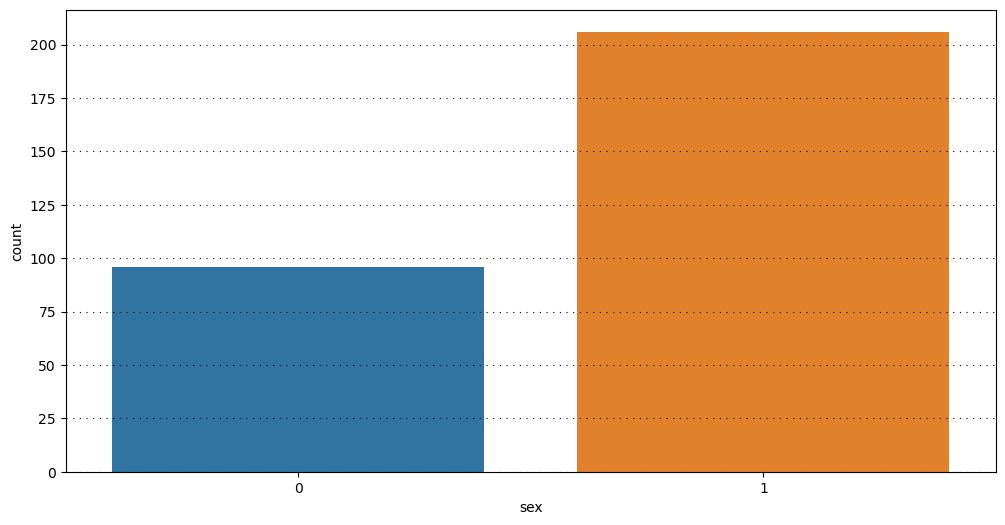

In [14]:
categorical_plot(df, "sex")

Observations:
* The number of people belonging to sex category "0" are 96 whereas "1" are 206.
* The number of people in category "1" are more than double than the "0" category.

<AxesSubplot: xlabel='cp', ylabel='count'>

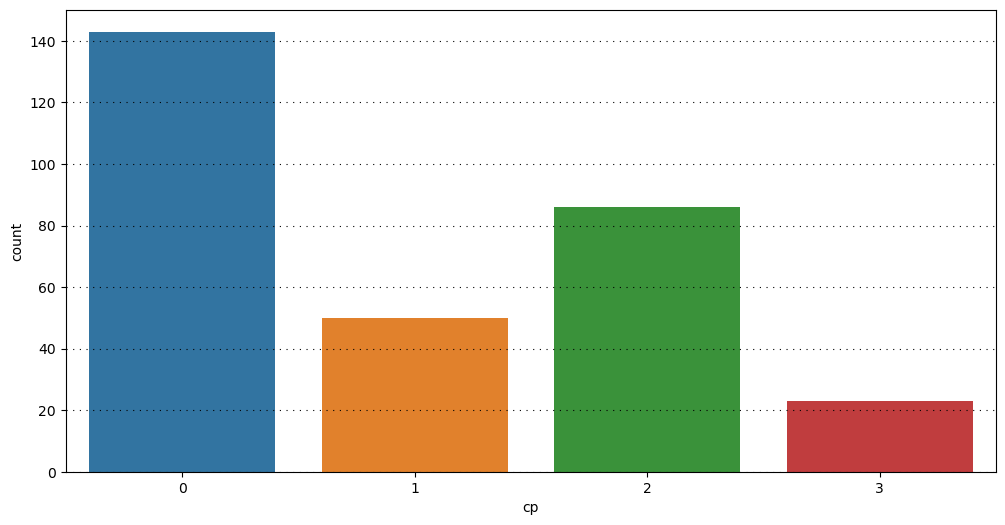

In [15]:
categorical_plot(df, "cp")

Observations:
* People of chest pain category '0' have the highest count, whereas of count of chest pain '3' is the lowest.

<AxesSubplot: xlabel='fbs', ylabel='count'>

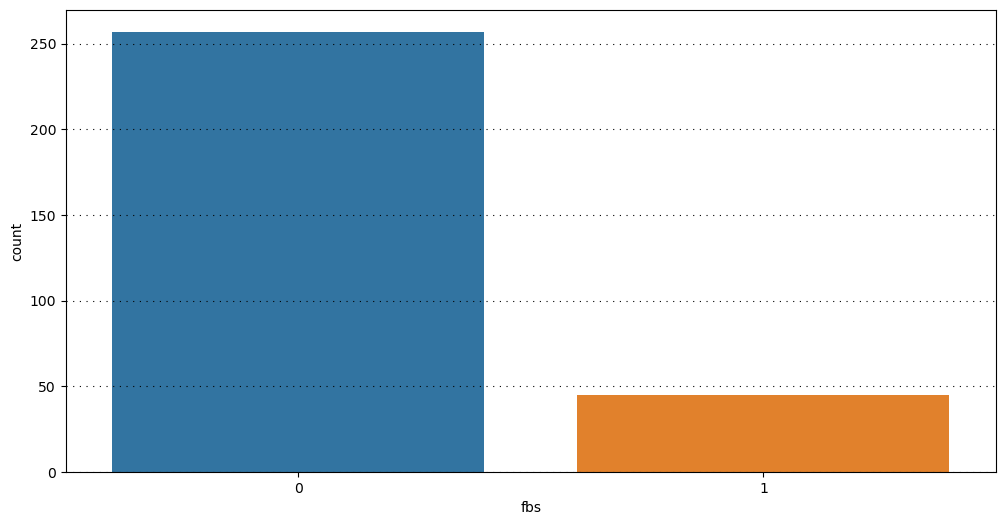

In [16]:
categorical_plot(df, "fbs")

Observations:
* People of fbs category "1" are less than 20% of people of fbs category "0".

<AxesSubplot: xlabel='thall', ylabel='count'>

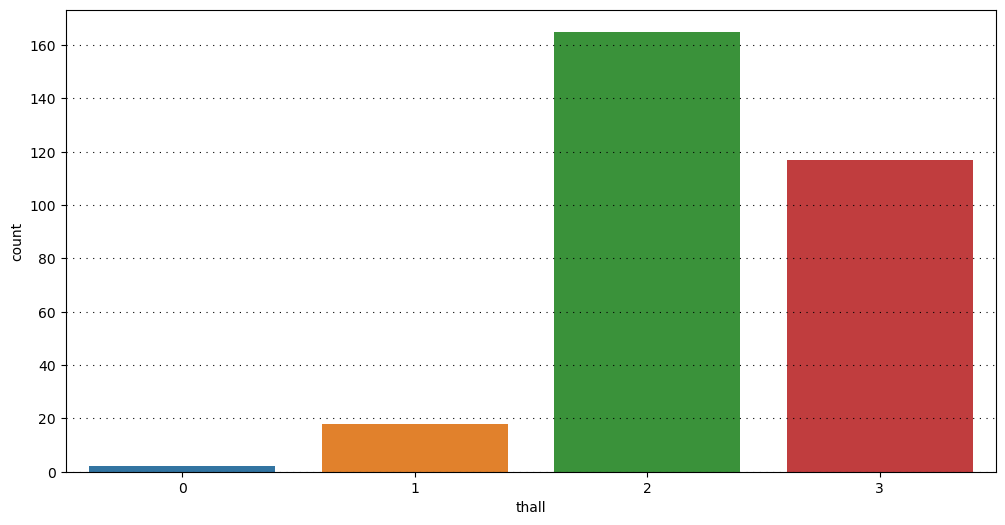

In [17]:
categorical_plot(df, "thall")

Observations:
* Thall count is maximum for type "2" (165) and min for type "0" (2).

<AxesSubplot: xlabel='restecg', ylabel='count'>

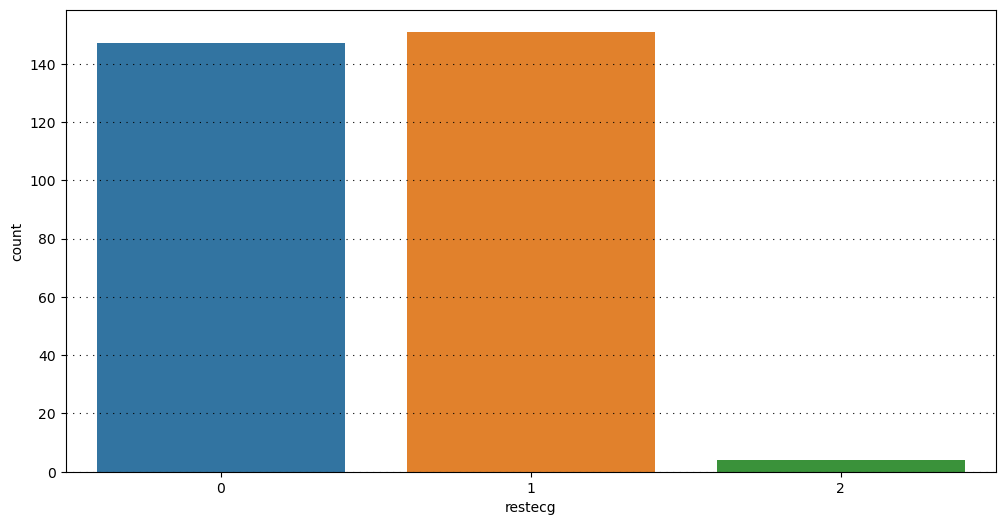

In [18]:
categorical_plot(df, "restecg")

Observations:
* restecg count is almost the same for type "0" and "1".
* Type "2" is almost nothing in comparison to "0" and "1"

<AxesSubplot: xlabel='caa', ylabel='count'>

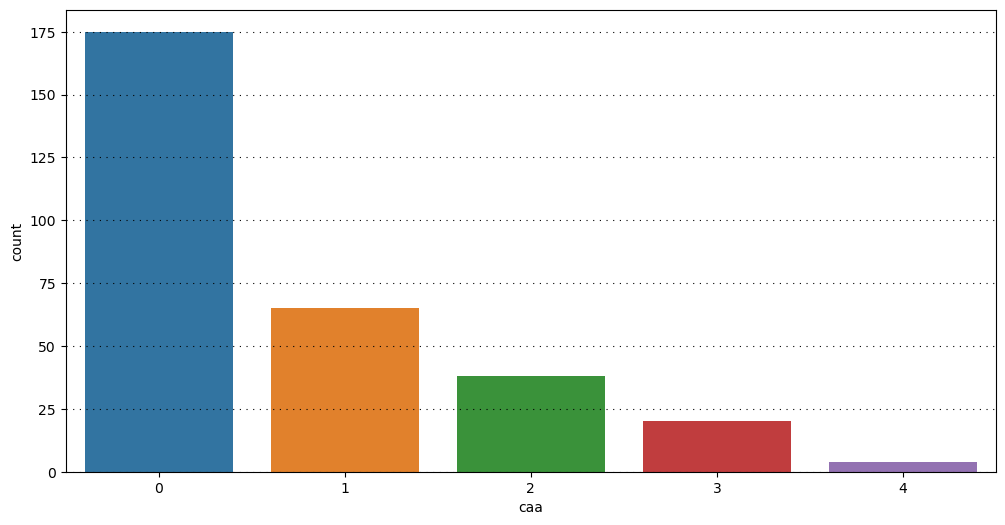

In [19]:
categorical_plot(df, "caa")

Observations:
* caa count is maximum for type "0" (175) and min for type "4" (~3).
* Type "0" counter at least 2 times bigger then others.

<AxesSubplot: xlabel='slp', ylabel='count'>

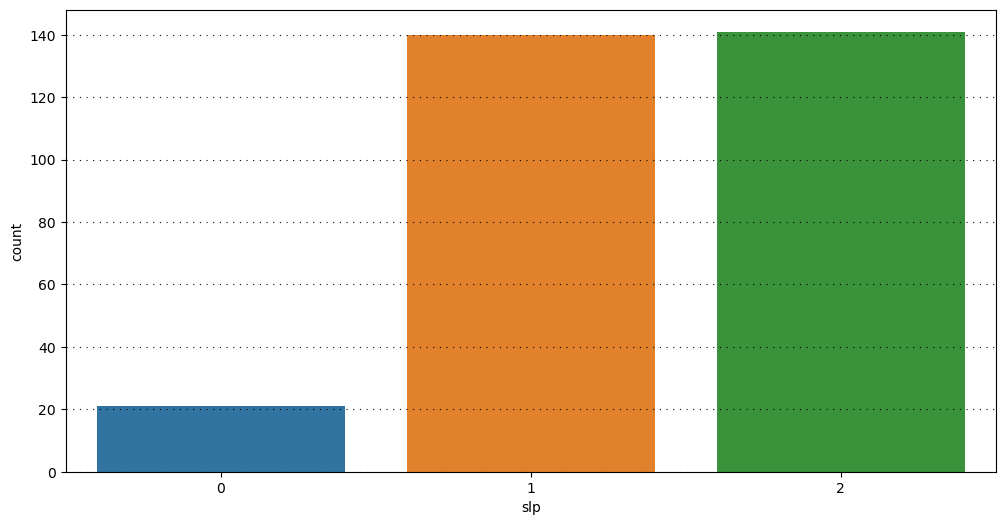

In [20]:
categorical_plot(df, "slp")

Observations:
* slp count is almost the same for type "1" and "2".
* Type "0" 7 times less

<AxesSubplot: xlabel='exng', ylabel='count'>

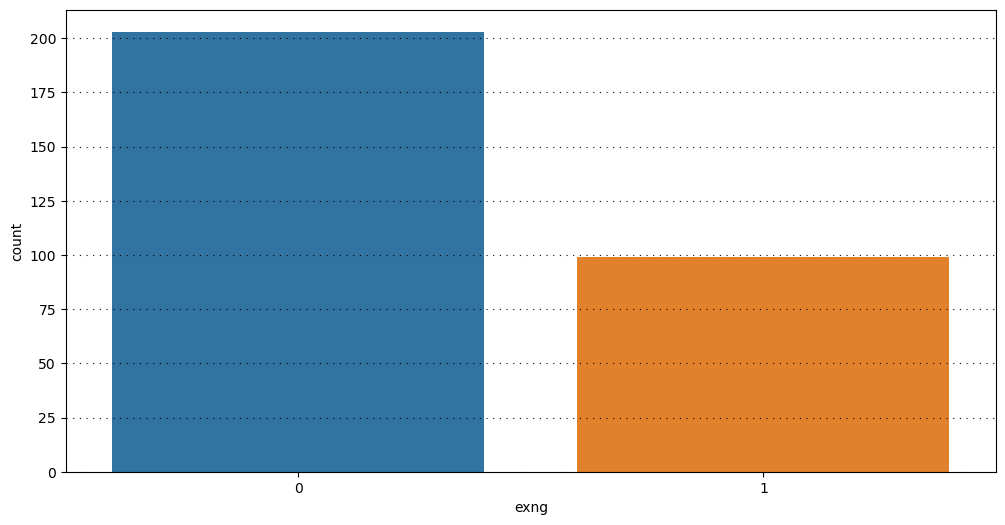

In [21]:
categorical_plot(df, "exng")

Observations:
* The number of people belonging to exng category "0" more then 200 whereas "1" are 98.
* The number of people in category "0" are more than double than the "1" category.

#### 3.1.2 Continuous features

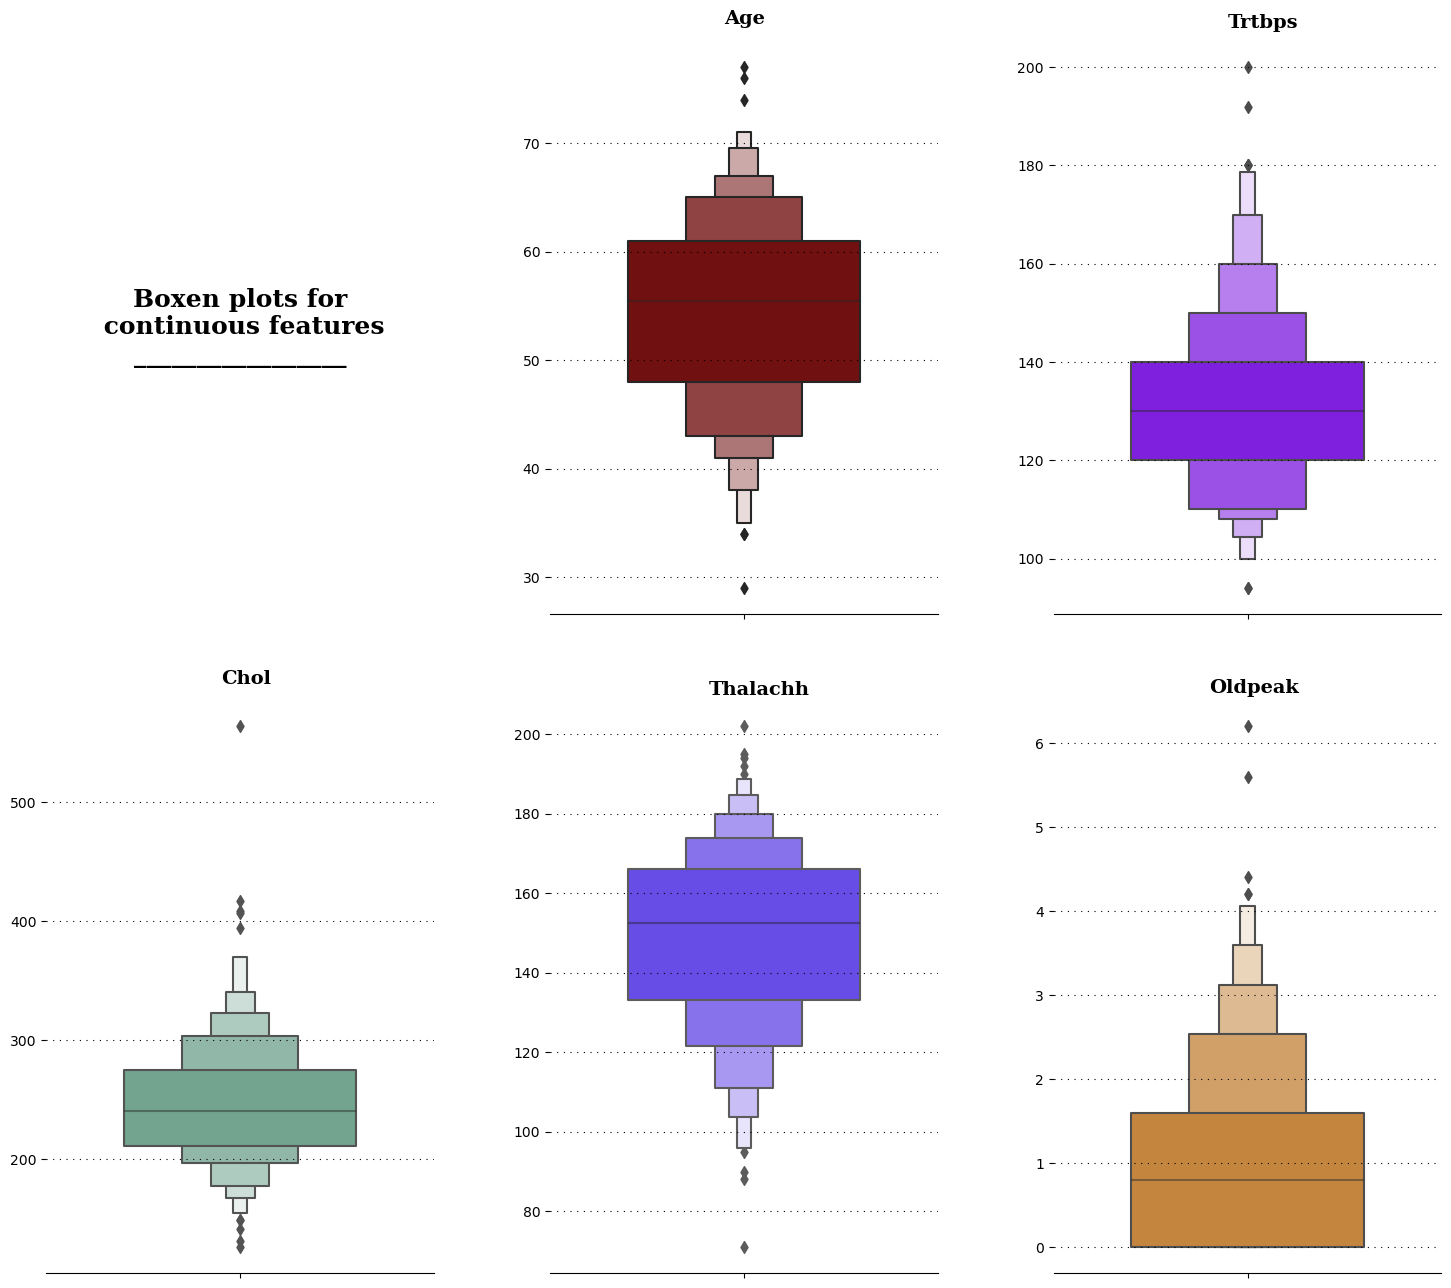

In [22]:
fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Boxen plots for\n continuous features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age 
ax1.text(-0.05, 81, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=df['age'],palette=["#800000"],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Trtbps 
ax2.text(-0.05, 208, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=df['trtbps'],palette=["#8000ff"],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol 
ax3.text(-0.05, 600, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=df['chol'],palette=["#6aac90"],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh 
ax4.text(-0.09, 210, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=df['thalachh'],palette=["#5833ff"],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak 
ax5.text(-0.1, 6.6, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=df['oldpeak'],palette=["#da8829"],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

#### 3.1.4 Distributions

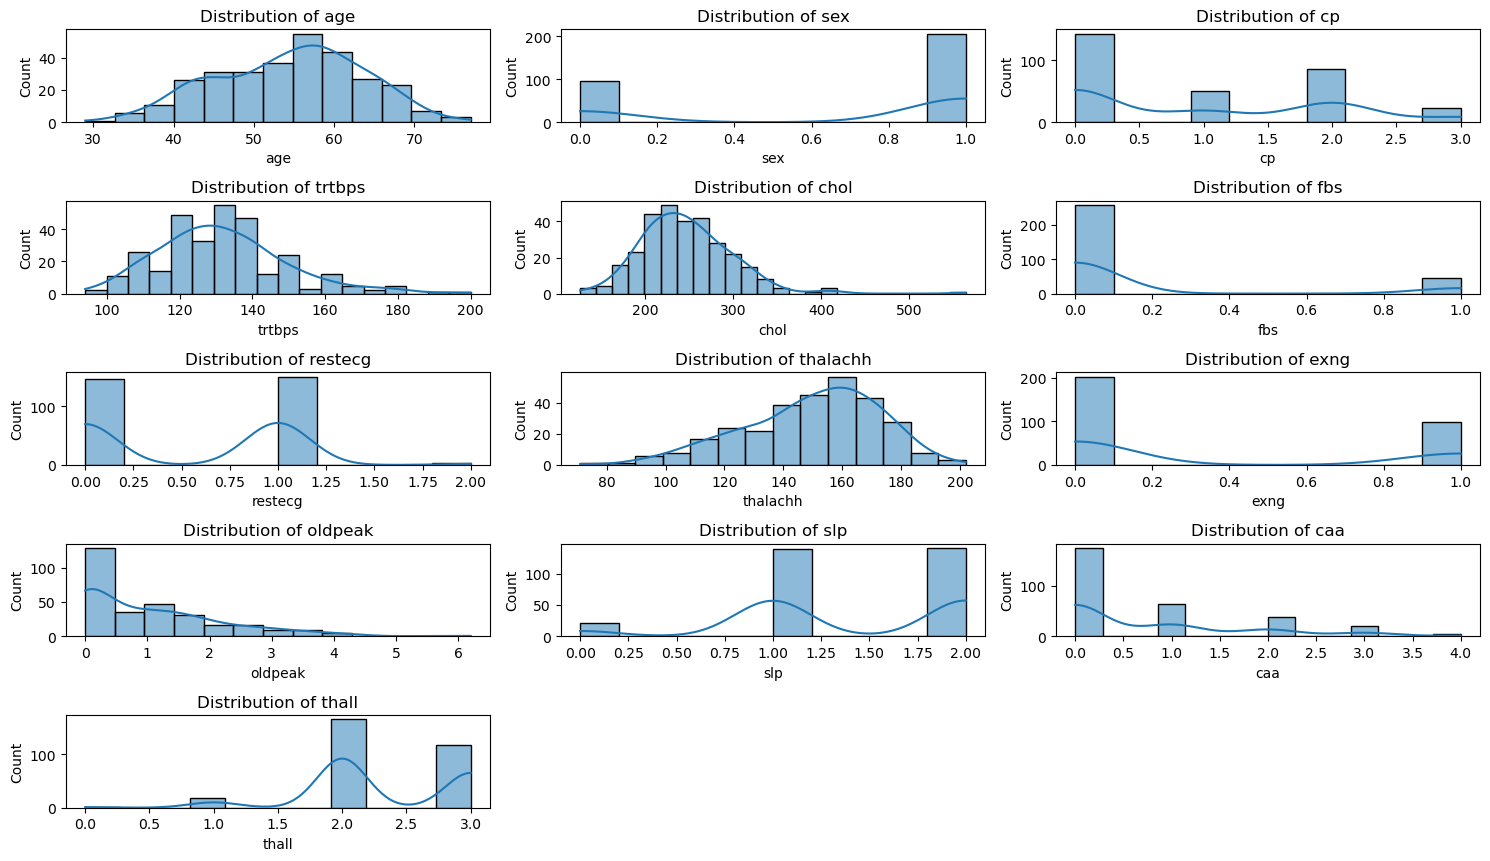

In [24]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(6,3,i)
    plt.title(f"Distribution of {col}")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

### 3.2. Bivariate Analysis

#### 3.2.1 Correlation matrix

In [25]:
df_corr = df[con_cols].corr().transpose()
df_corr

,age,trtbps,chol,thalachh,oldpeak
age,1.000000,0.283121,0.207216,-0.395235,0.206040
trtbps,0.283121,1.000000,0.125256,-0.048023,0.194600
chol,0.207216,0.125256,1.000000,-0.005308,0.050086
thalachh,-0.395235,-0.048023,-0.005308,1.000000,-0.342201
oldpeak,0.206040,0.194600,0.050086,-0.342201,1.000000


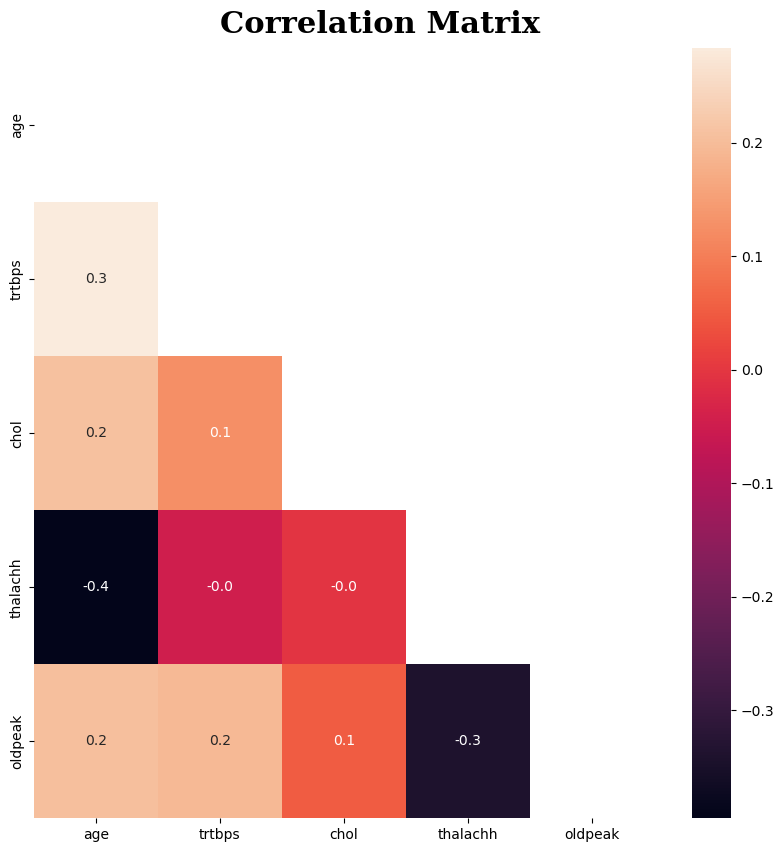

In [26]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])

mask = np.triu(np.ones_like(df_corr))
ax0.text(1.5,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
df_corr = df[con_cols].corr().transpose()
sns.heatmap(df_corr,mask=mask,fmt=".1f",annot=True)
plt.show()

#### 3.2.2 Distributions

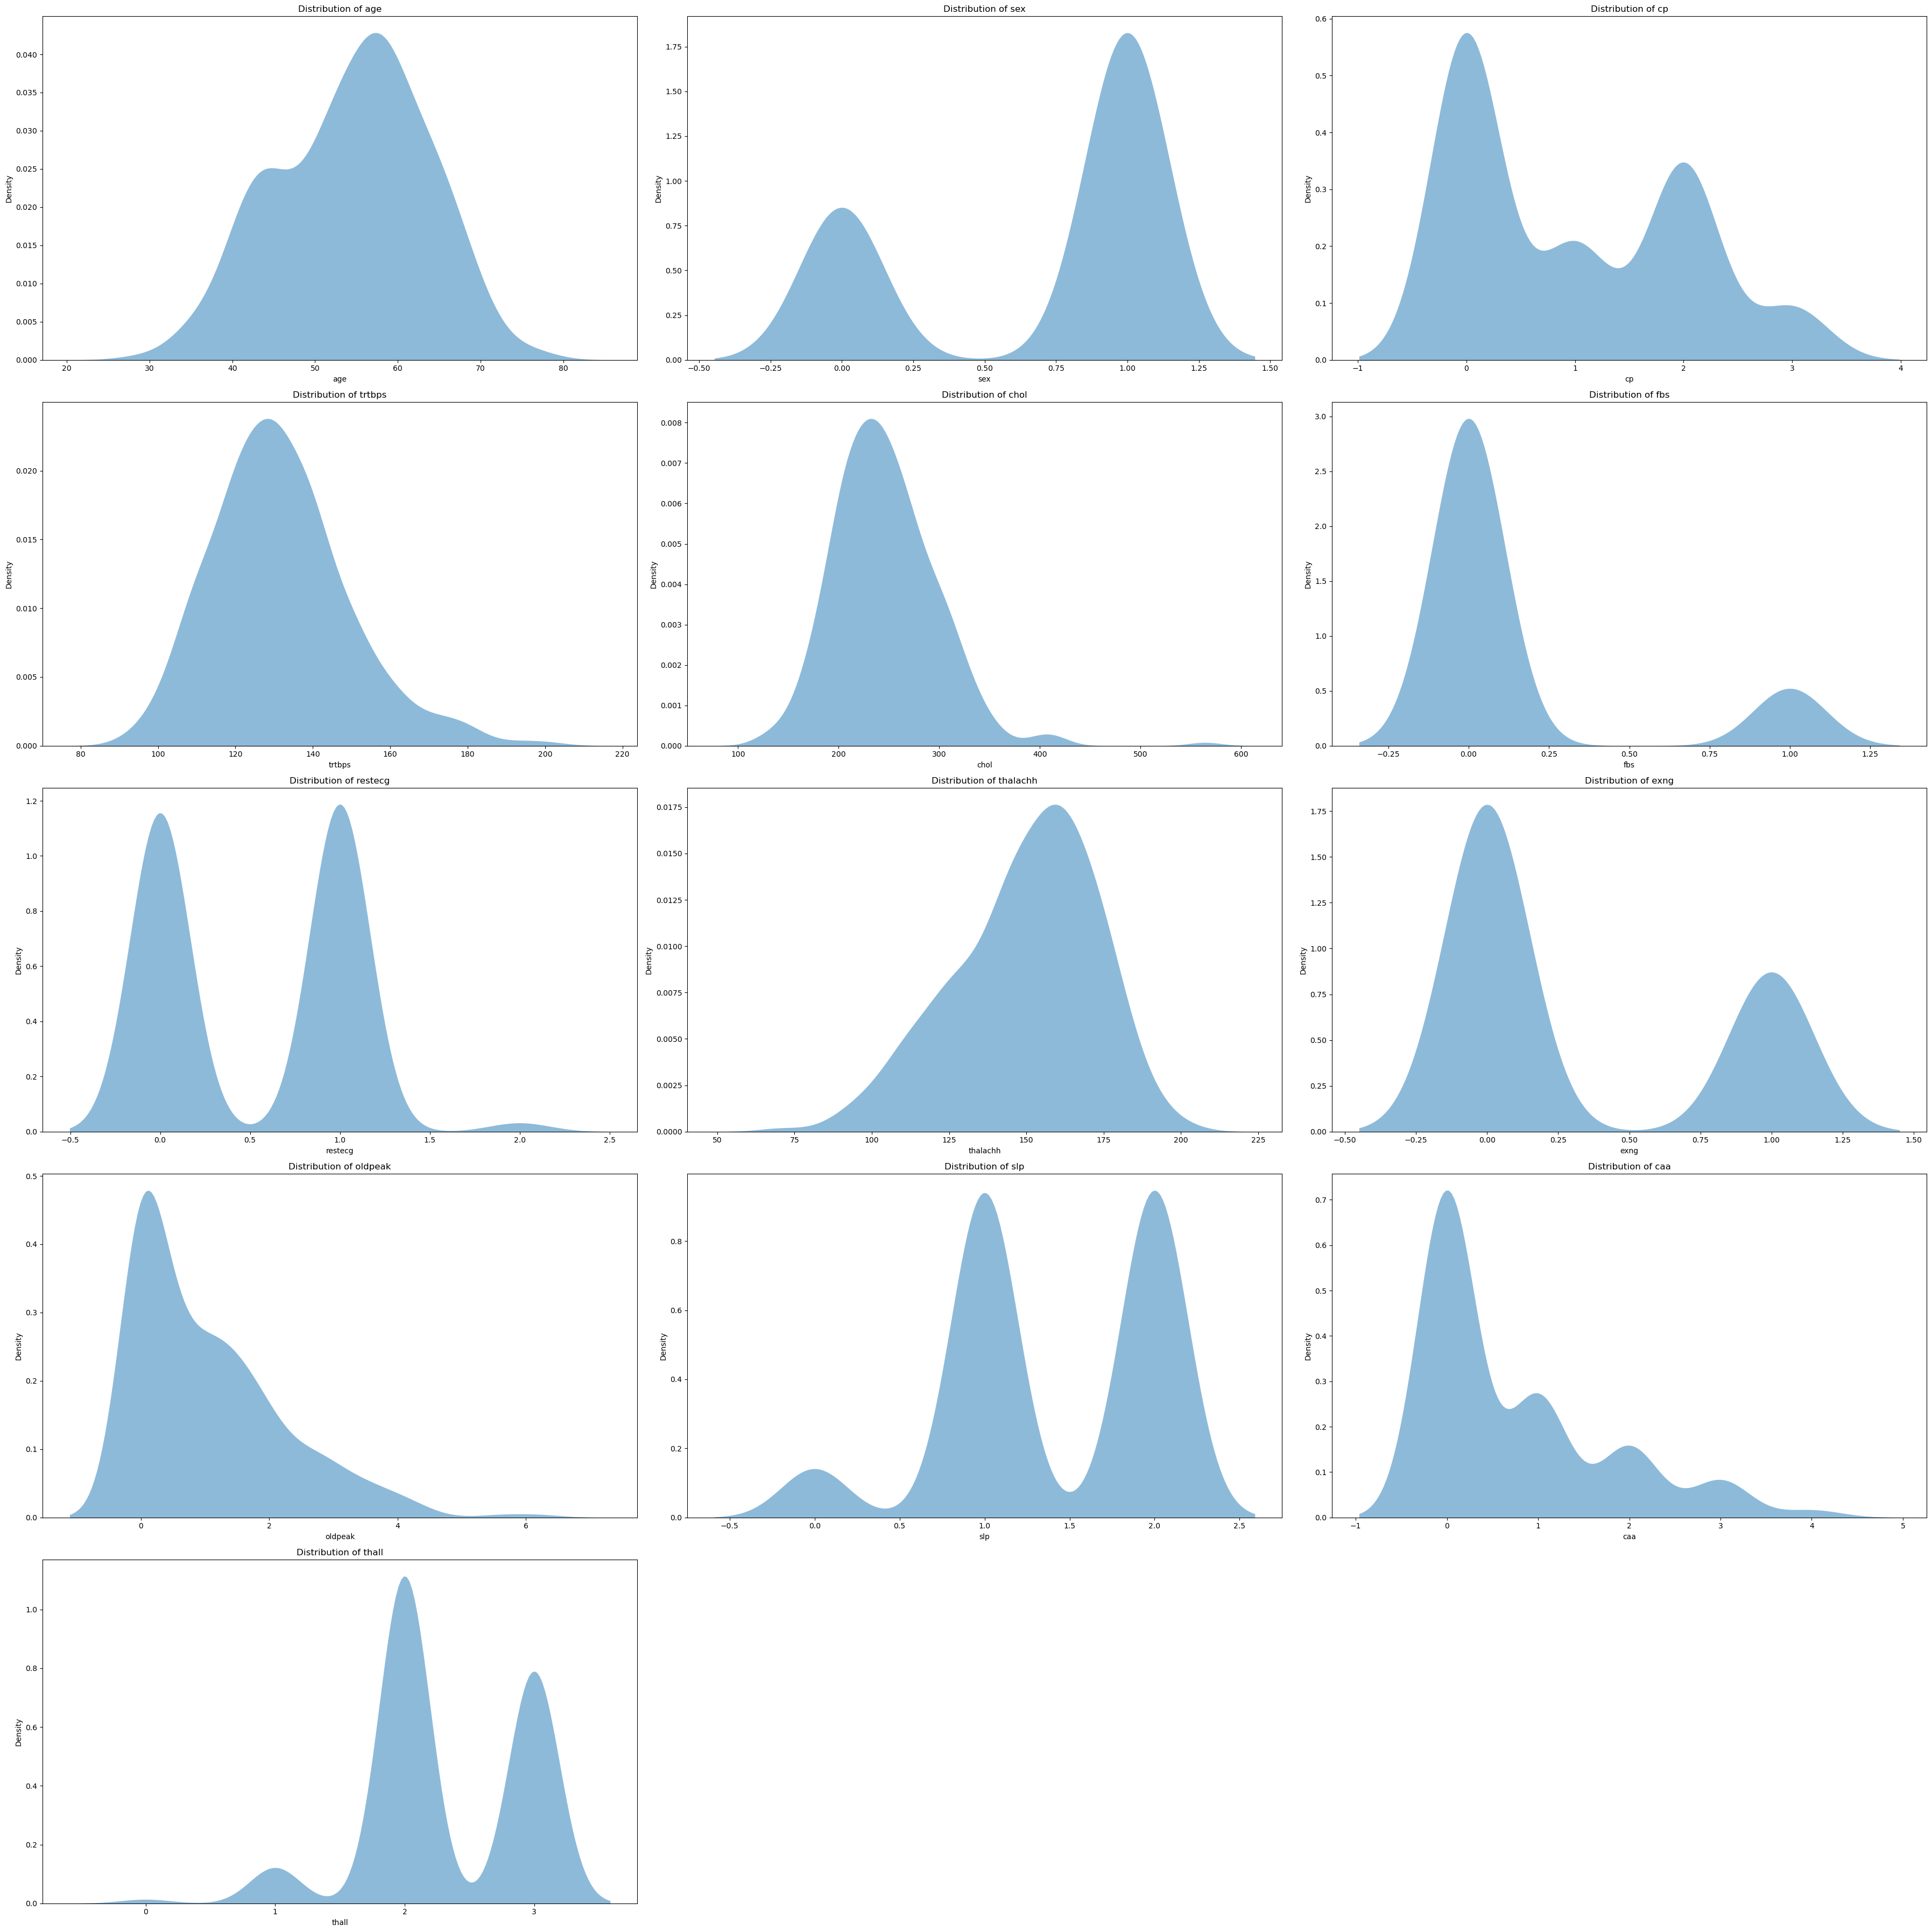

In [28]:
plt.figure(figsize=(36,36))
for i,col in enumerate(df.columns,1):
    plt.subplot(5,3,i)
    plt.title(f"Distribution of {col}")
    sns.kdeplot(data=df, x=col, fill=True, alpha=.5, linewidth=0)
    plt.tight_layout()
    plt.plot()

#### 3.2.3 Pairplot according to target variable

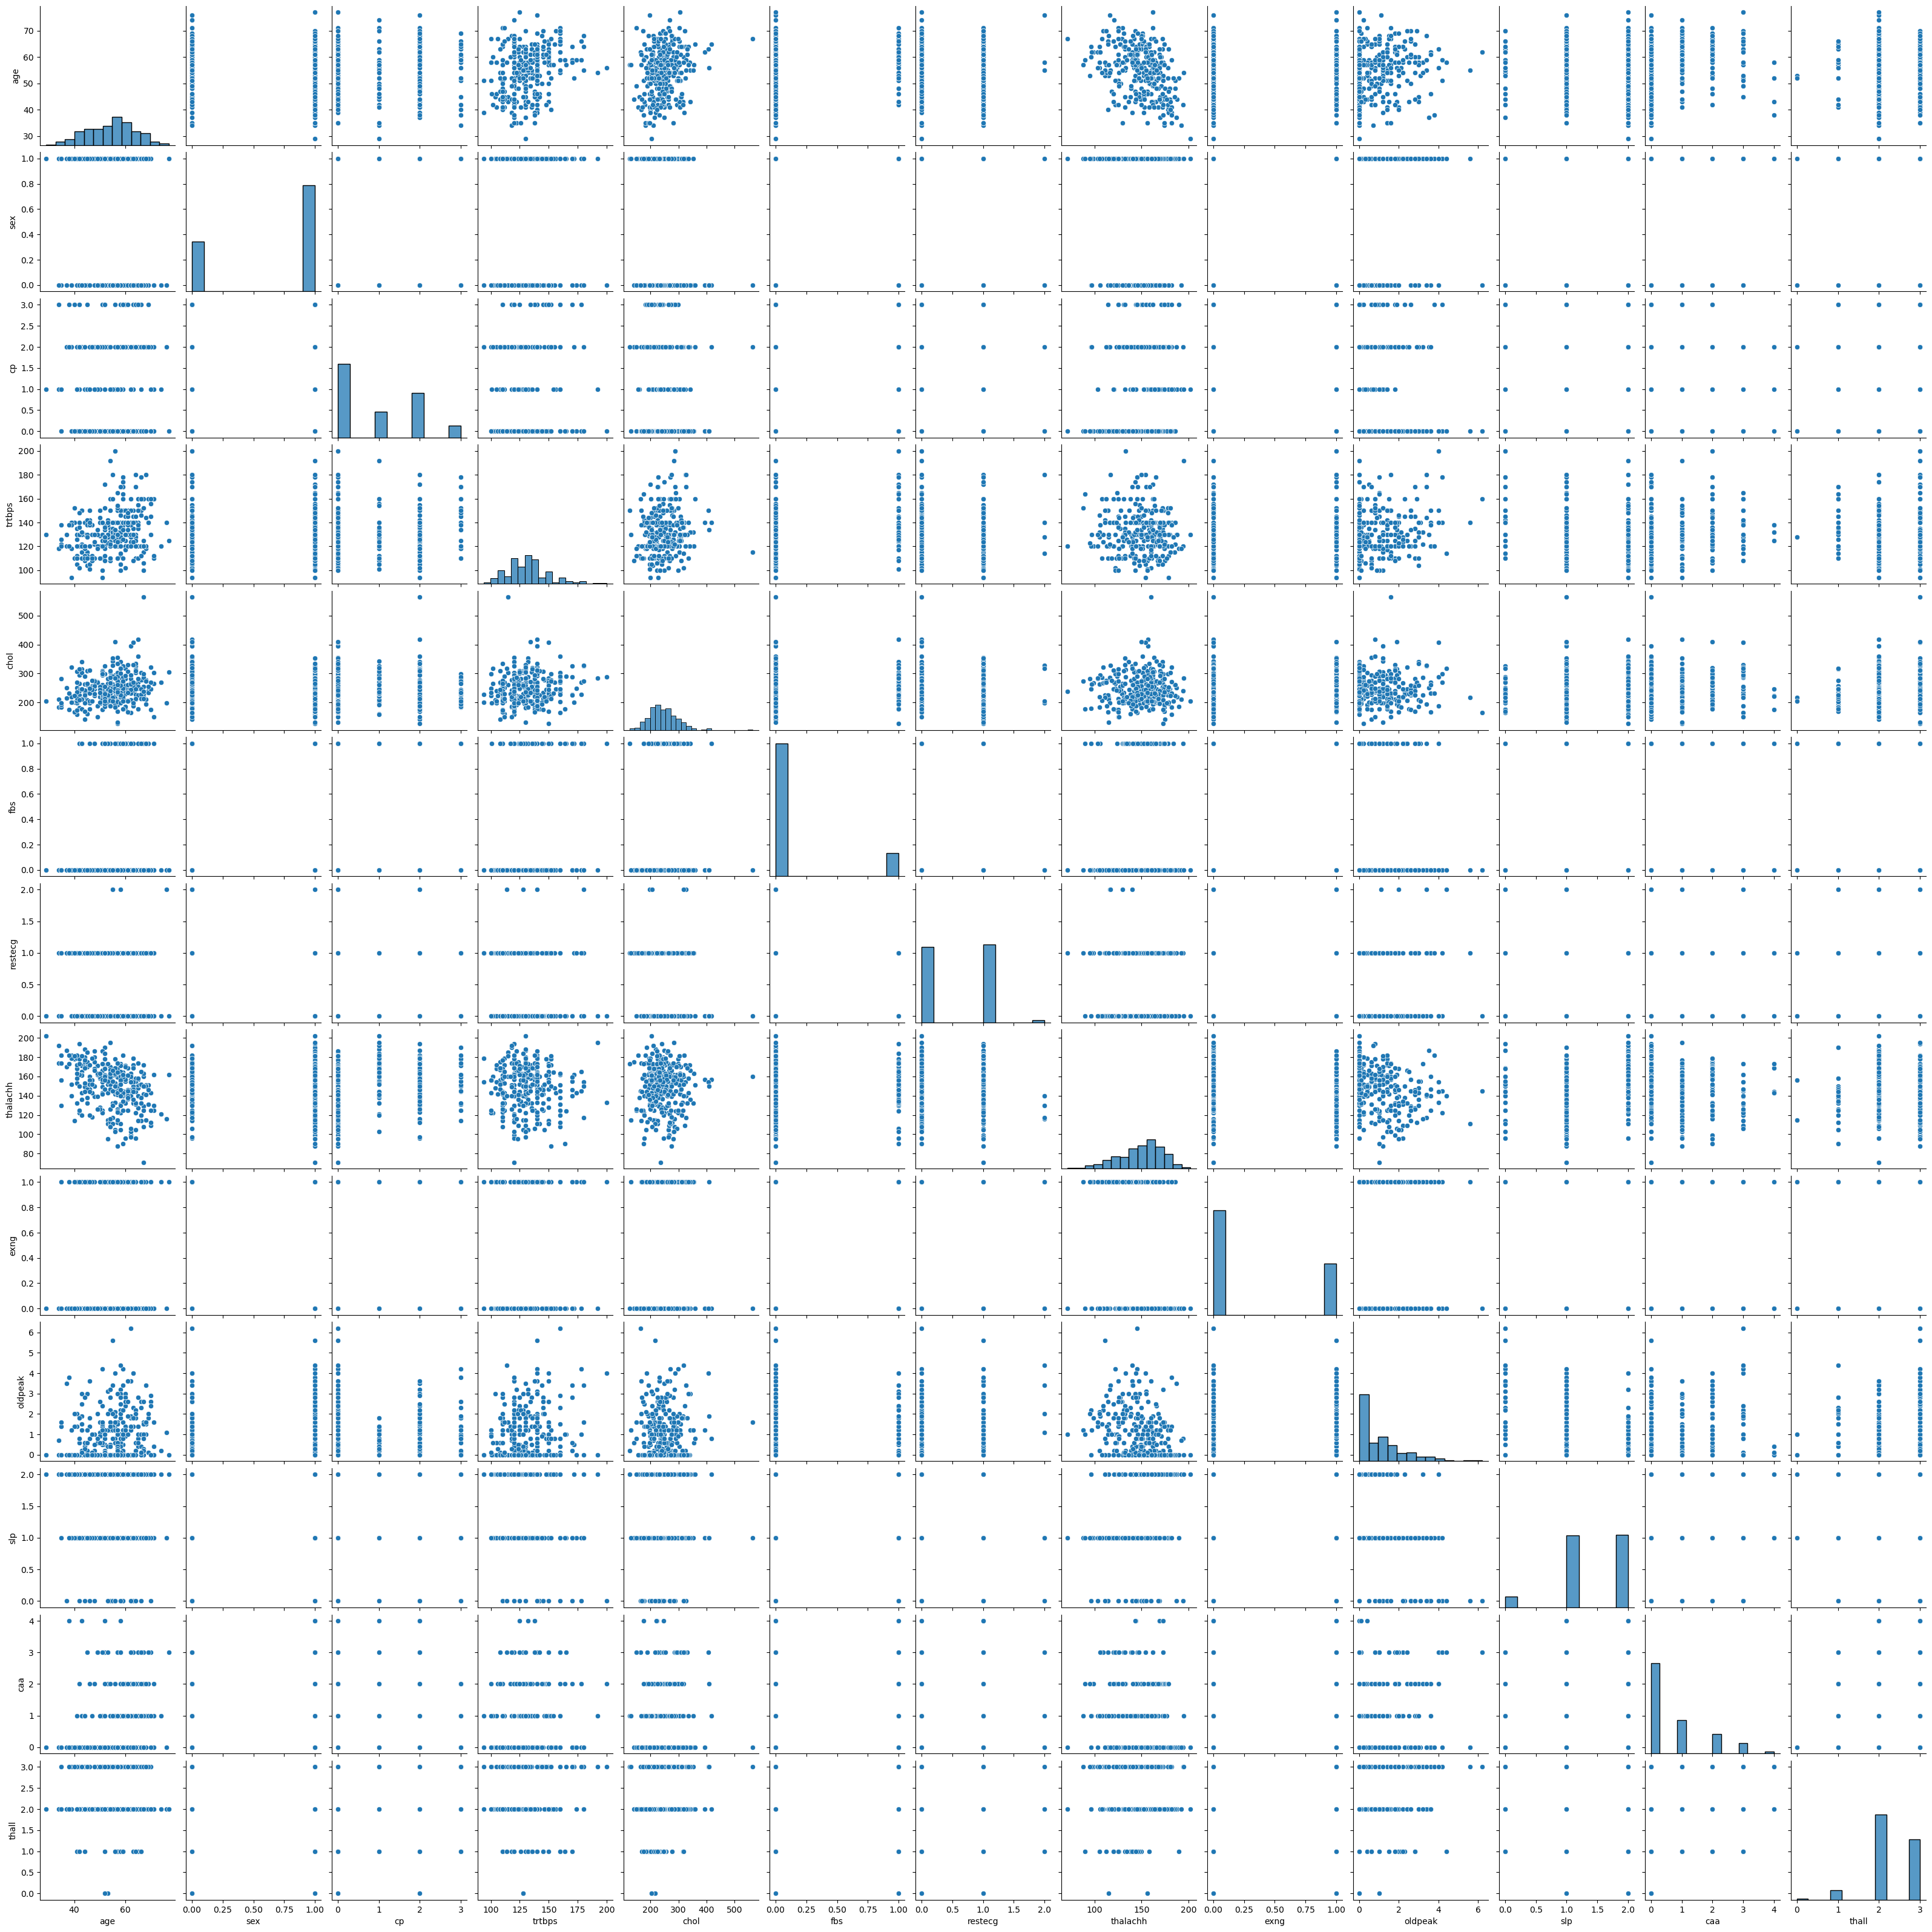

In [29]:
sns.pairplot(df)
plt.show()

### Conclusions

* There are no NaN values in the data.
* There are certain outliers in all the continuous features.
* The data consists of more than twice the number of people with sex = 1 than sex = 0.
* There is no apparent linear correlation between continuous variable according to the heatmap.
* It is intuitive that elder people might have higher chances of heart attack but according to the distribution plot of age wrt * output, it is evident that this isn't the case.
* According to the distribution plot of thalachh wrt output, people with higher maximum heart rate achieved have higher chances of  heart attack.
* According to the distribution plot of oldpeak wrt output, people with lower pevious peak achieved have higher chances of heart * attack.


## 4. Data processing

In [ ]:
# Scaling
from sklearn.preprocessing import RobustScaler

# Train Test Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Preprocessing incudes several steps:
* Handling of null values
* Outlier handling
* Categorical features encoding
* Feature scaling
* Train and Test split

### 4.1 Handling Null Values

On this step we need to handle any null (NaN) values in our dataset if we did not do it previously.

Our dataset hasn't any null values, so we skip it.


### 4.2 Outliers

As it was shown on boxenplots, there are some outliers.
There are 2 ways of handling:
* Remove them
* Scale them in a way that they don't change the results.

Our dataset is relative small, so we will use the second approach.
we can use Robust Scaling for scakling our data, It scales features using statistics that are robust to outliers. This method removes the median and scales the data in the range between 1st quartile and 3rd quartile. i.e., in between 25th quantile and 75th quantile range. If outliers are present in the dataset, then the median and the interquartile range provide better results and outperform the sample mean and variance. RobustScaler uses the interquartile range so that it is robust to outliers.



### 4.2 Categorical features encoding

All our categorical features are already encoded by the dataset.

### 4.3 Handling Categorical Variables

Categorical variables/features are any feature type can be classified into two major types:

* Nominal
* Ordinal

Nominal variables are variables that have two or more categories which do not have any kind of order associated with them. For example, if gender is classified into two groups, i.e. male and female, it can be considered as a nominal variable.Ordinal variables, on the other hand, have “levels” or categories with a particular order associated with them. For example, an ordinal categorical variable can be a feature with three different levels: low, medium and high. Order is important.

It is a binary classification problem: the target here is not skewed but we use the best metric for this binary classification problem which would be Area Under the ROC Curve (AUC). We can use precision and recall too, but AUC combines these two metrics. Thus, we will be using AUC to evaluate the model that we build on this dataset.

We have to know that computers do not understand text data and thus, we need to convert these categories to numbers. A simple way of doing that can be to use :

* Label Encoding

  from sklearn.preprocessing import LabelEncoder

* One Hot Encoding

  pd.get_dummies()

but we need to understand where to use which type of label encoding:

**For not Tree based Machine Learning Algorithms the best way to go will be to use One-Hot Encoding**

* One-Hot-Encoding has the advantage that the result is binary rather than ordinal and that everything sits in an orthogonal vector space.
* The disadvantage is that for high cardinality, the feature space can really blow up quickly and you start fighting with the curse of dimensionality. In these cases, I typically employ one-hot-encoding followed by PCA for dimensionality reduction. I find that the judicious combination of one-hot plus PCA can seldom be beat by other encoding schemes. PCA finds the linear overlap, so will naturally tend to group similar features into the same feature

**For Tree based Machine Learning Algorithms the best way to go is with Label Encoding**

* LabelEncoder can turn [dog,cat,dog,mouse,cat] into [1,2,1,3,2], but then the imposed ordinality means that the average of dog and mouse is cat. Still there are algorithms like decision trees and random forests that can work with categorical variables just fine and LabelEncoder can be used to store values using less disk space.

##### Decision

We will use One-Hot Encoding, because:
* our goal to perform dimensionality reduction and this encoding will give us many features for reduction.


In [ ]:
# creating a copy of df
df1 = df

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

### 4.4 Feature scaling

##### Why Should we Use Feature Scaling?
The first question we need to address – why do we need to scale the variables in our dataset? Some machine learning algorithms are sensitive to feature scaling while others are virtually invariant to it. Let me explain that in more detail.

Distance Based Algorithms:

Distance algorithms like "KNN", "K-means" and "SVM" are most affected by the range of features. This is because behind the scenes they are using distances between data points to determine their similarity. Whem two features have different scales, there is a chance that higher weightage is given to features with higher magnitude. This will impact the performance of the machine learning algorithm and obviously, we do not want our algorithm to be biassed towards one feature.

Therefore, we scale our data before employing a distance based algorithm so that all the features contribute equally to the result.

Tree-Based Algorithms:

Tree-based algorithms, on the other hand, are fairly insensitive to the scale of the features. Think about it, a decision tree is only splitting a node based on a single feature. The decision tree splits a node on a feature that increases the homogeneity of the node. This split on a feature is not influenced by other features.

So, there is virtually no effect of the remaining features on the split. This is what makes them invariant to the scale of the features!

In [ ]:
scaler = RobustScaler()

df1[con_cols] = scaler.fit_transform(df1[con_cols])

## 5. Modeling

### 5.1 Dimention reduction

In [ ]:
df

In [ ]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 6):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': data.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

#### 5.1.1 Logistic Regression

In [ ]:
clf=LogisticRegression()
clf.fit(X_train,y_train)
y_pred_proba = clf.predict_proba(X_test)

y_pred = np.argmax(y_pred_proba,axis=1)

print("The test accuracy score of Logistric Regression is ", accuracy_score(y_test, y_pred))

The test accuracy score of Logistric Regression is  0.9180327868852459


#### 5.1.2 Support Vector Machines (SVM)

In [ ]:
clf = SVC(kernel='linear', C=1, random_state=29).fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("The test accuracy score of SVM is ", accuracy_score(y_test, y_pred))

The test accuracy score of SVM is  0.8852459016393442


#### 5.1.3 Naive Bayers

In [ ]:
clf=GaussianNB()

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("The test accuracy score of GaussianNB is ", accuracy_score(y_test, y_pred))

The test accuracy score of GaussianNB is  0.9180327868852459


### 5.2 Tree Models

#### 5.2.1 Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state = 29)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("The test accuracy score of Decision Tree is ", accuracy_score(y_test, y_pred))

The test accuracy score of Decision Tree is  0.7868852459016393


#### 5.2.2 Random Forest

In [ ]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("The test accuracy score of Random Forest is ", accuracy_score(y_test, y_pred))

The test accuracy score of Random Forest is  0.7868852459016393


#### 5.2.3 Gradient Boost

In [ ]:
gbt = GradientBoostingClassifier(n_estimators = 300,max_depth=1,subsample=0.8,max_features=0.2,random_state=29)

gbt.fit(X_train,y_train)

y_pred = gbt.predict(X_test)

print("The test accuracy score of Gradient Boosting Classifier is ", accuracy_score(y_test, y_pred))

The test accuracy score of Gradient Boosting Classifier is  0.9180327868852459


#### 5.2.4 AdaBoost

In [ ]:
cls = AdaBoostClassifier(learning_rate= 0.15,n_estimators= 25)
cls.fit(X_train, y_train)
y_pred= cls.predict(X_test)
print("The test accuracy score of Gradient Boosting Classifier is ", accuracy_score(y_test, y_pred))

The test accuracy score of Gradient Boosting Classifier is  0.9180327868852459


### 5.3 Hyperparameter tuning
To tune our classifiers we use `GridSearchCV` with parameter grids as follows:

In [ ]:
Parameters_Grid = {
    "LogisticRegression" : [
        LogisticRegression(random_state=29),
        {
        }
    ],
    "SVC" : [
        SVC(random_state=29),
        {
            "C": np.arange(1,10,1),
            "gamma": [0.00001,0.00005, 0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5],
            "kernel": ['linear', 'sigmoid', 'rbf', 'poly']
        }
    ],
    "GaussianNB" : [
        GaussianNB(),
        {
        }
    ],
    "DecisionTreeClassifier" : [
        DecisionTreeClassifier(random_state=29),
        {
            'criterion': ['gini','entropy'],
            'splitter':  ['best','random'],
            'max_features': ["auto","sqrt","log2"],
            'max_leaf_nodes': [2,3,4,5,6,7,8,9,10]
        }
    ],
    "RandomForestClassifier" : [
        RandomForestClassifier(random_state=29),
        {
            'n_estimators': [1,2,3,5,8,9,10,11,15,20,21],
            'criterion': ['gini','entropy'],
            'max_features': ["auto","sqrt","log2"],
            'max_leaf_nodes': [2,3,4,5,6,7,8,9,10]
        }
    ],
    "GradientBoostingClassifier" : [
        GradientBoostingClassifier(random_state=29),
        {
            'n_estimators' : [10, 100, 300, 500],
            'learning_rate' : [0.001, 0.01, 0.1, 0.15, 0.25],
            'subsample' : [0.5, 0.7, 1.0],
            'max_depth' : [1, 2, 3, 7, 9]
        }
    ],
    "AdaBoostClassifier" : [
        AdaBoostClassifier(random_state=29),
        {
            'n_estimators': [1,2,3,5,8,9,10,25, 50, 100, 500],
            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5]
        }
    ]
}

In [ ]:
for svr in Parameters_Grid:
    clf = GridSearchCV(Parameters_Grid[svr][0],Parameters_Grid[svr][1])
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(svr,accuracy_score(y_test, y_pred))


LogisticRegression 0.9180327868852459
SVC 0.9344262295081968
GaussianNB 0.9180327868852459
DecisionTreeClassifier 0.8360655737704918
RandomForestClassifier 0.9016393442622951
GradientBoostingClassifier 0.9016393442622951
AdaBoostClassifier 0.9180327868852459


* Most of all models reach accuracy of 90%
* The best results has SVC classifier with hyperparameters as follows: {'C': 8, 'gamma': 1e-05, 'kernel': 'linear'}
  with accuracy of 93%

## 6. Conclusions

* In my opinion with such data in future, we will minimize the number of heart attack by early detection.
* I recommend to use SVC classifier with hyperparameters as follows: {'C': 8, 'gamma': 1e-05, 'kernel': 'linear'}.
  Such configuration could give accuracy of 93%.
* High Blood Pressure, High Cholestrol and High Heart Rate leads to high chance of heart attack.
* Age from 40-60 years have the high chance of heart attack.
* Highly Correlated factors in this dataset are :

  * Age and trtbps (blood pressure rate)
  * Age and chol (cholestrol level)


## 7. Next steps

* One of possible future steps is future engineering to create a new feature
* Also, we use dummy encoding for categorical features, that leads to more number of feature.
  It would be a good idea to reduce the number of features using some algorithm, or simple feature selection.